In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Load Raw Data

In [2]:
folder_data = 'data/'
fn_data = 'tmb_mskcc_2018_clinical_data.tsv'
fp_data = os.path.join(folder_data, fn_data)

In [3]:
raw_data_df = pd.read_csv(fp_data, sep='\t', index_col=1)
print('Number of records:', raw_data_df.shape[0])
raw_data_df.head(4)

Number of records: 1661


,Study ID,Sample ID,Age at Which Sequencing was Reported (Days),Age Group at Diagnosis in Years,Cancer Type,Cancer Type Detailed,Drug Type,Gene Panel,Institute Source,Metastatic Site,...,Overall Survival Status,Primary Tumor Site,Sample Class,Number of Samples Per Patient,Sample coverage,Sample Type,Sex,Somatic Status,TMB Score,Tumor Purity
Patient ID,,,,,,,,,,,,,,,,,,,,,
P-0000057,tmb_mskcc_2018,P-0000057-T01-IM3,41.0,31-50,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,1:DECEASED,Breast,Tumor,1,835,Primary,Female,Matched,5.580000,25
P-0000062,tmb_mskcc_2018,P-0000062-T01-IM3,80.0,>71,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,1:DECEASED,Esophagus,Tumor,1,1176,Primary,Male,Matched,6.691462,30
P-0000063,tmb_mskcc_2018,P-0000063-T01-IM3,62.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,0:LIVING,Bladder,Tumor,1,900,Primary,Male,Matched,16.728656,70
P-0000071,tmb_mskcc_2018,P-0000071-T01-IM3,66.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,0:LIVING,Bladder,Tumor,1,795,Primary,Male,Matched,11.152437,30


## Constructure the time series dataframe and check matrix rank

In [4]:
def construct_ts_matrix(data_df, unit_defined_by=None, filter_by_column=None):
    """Returns a time series matrix for units.
    
    Args:
      data_df: The input dataframe.
      unit_defined_by: A column whose values will be used to group the rows of data_df to form units.
        If None, each row will be one unit.
      filter_by_column: A dict where the keys are column names and values are column values. If given,
        only rows with the matched column values are kept.
    """
    if filter_by_column:
      to_keep = None  
      for k,v in filter_by_column.items():
        if to_keep is None:
          to_keep = (data_df[k] == v)
        else:
          to_keep = (filter_flags & (data_df[k] == v))
      data_df = data_df[to_keep]
    
    # Next, besides survival data, we only keep the column used to define units.
    data_df = data_df[[unit_defined_by, KEY_SURVIVAL_MONTH]]
    units = sorted(list(set(data_df[unit_defined_by])))
    max_survival_mo = int(np.floor(np.max(data_df[KEY_SURVIVAL_MONTH])))
    ts_matrix = np.zeros((len(units), max_survival_mo), dtype=np.float)
     
    for i, u in enumerate(units):
      # The survival months for all patients in this unit.
      survival_mos = data_df[data_df[unit_defined_by]==u][KEY_SURVIVAL_MONTH].to_numpy()   
      n_patients_in_unit = len(survival_mos)
      # Now we want to know how many of them survived for 1 month, 2 months, ....
      survival_counts = [np.sum(survival_mos >= i) for i in range(1, max_survival_mo + 1)]
      ts_matrix[i,:] = np.array(survival_counts) / n_patients_in_unit
    return ts_matrix, units

def plot_spectrum(ts_matrix):
  (U, s, Vh) = np.linalg.svd((ts_matrix) - np.mean(ts_matrix))
  s2 = np.power(s, 2)
  spectrum = np.cumsum(s2)/np.sum(s2)

  plt.plot(spectrum)
  plt.grid()
  plt.title("Cumulative energy")
  plt.figure()
  plt.plot(s2)
  plt.grid()
  plt.xlabel("Ordered Singular Values") 
  plt.ylabel("Energy")
  plt.title("Singular Value Spectrum")


def analyze_ts_matrix_rank(drug_type):
  ts_matrix, units = construct_ts_matrix(
      data_df,
      unit_defined_by=KEY_CANCER_TYPE,
      filter_by_column={KEY_DRUG_TYPE:drug_type})
  ts_df = pd.DataFrame(data=ts_matrix, index=units, columns=range(1, ts_matrix.shape[1]+1))
  plot_spectrum(ts_df)
  return ts_df

In [5]:
KEY_SURVIVAL_MONTH = 'Overall Survival (Months)'
KEY_CANCER_TYPE = 'Cancer Type'
KEY_DRUG_TYPE = 'Drug Type'
KEY_PATIENT_ID = 'Patient ID'

data_df = raw_data_df[[KEY_CANCER_TYPE, KEY_DRUG_TYPE, KEY_SURVIVAL_MONTH]]
data_df.head(4)

,Cancer Type,Drug Type,Overall Survival (Months)
Patient ID,,,
P-0000057,Breast Cancer,PD-1/PDL-1,0
P-0000062,Esophagogastric Cancer,PD-1/PDL-1,1
P-0000063,Bladder Cancer,PD-1/PDL-1,42
P-0000071,Bladder Cancer,PD-1/PDL-1,43


<AxesSubplot:>

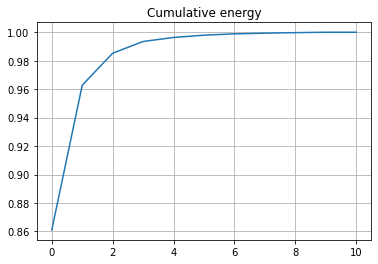

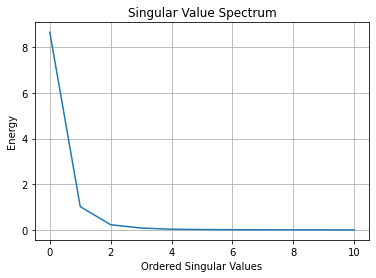

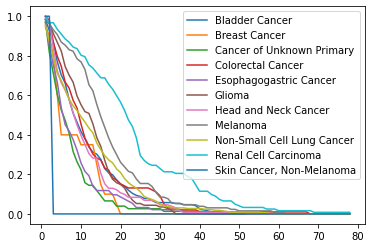

In [6]:
ts_pd1_df = analyze_ts_matrix_rank('PD-1/PDL-1')
ts_pd1_df.transpose().plot()

<AxesSubplot:>

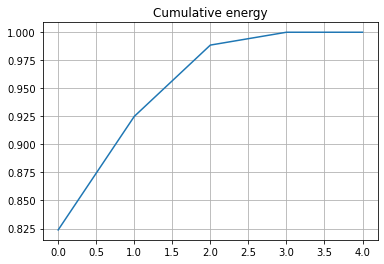

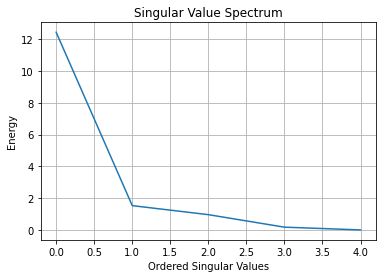

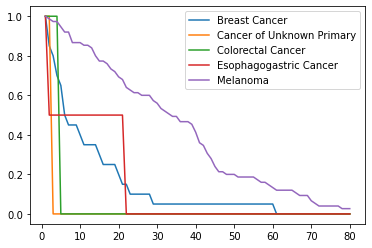

In [7]:
ts_ctla4_df = analyze_ts_matrix_rank('CTLA4')
ts_ctla4_df.transpose().plot()

<AxesSubplot:>

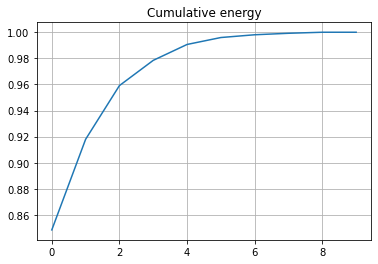

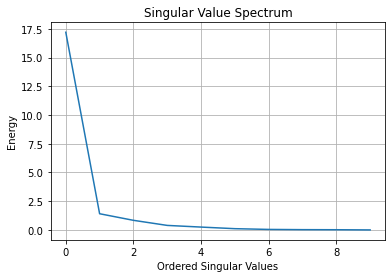

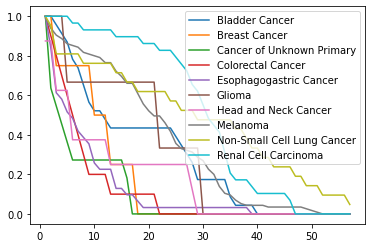

In [8]:
ts_combo_df = analyze_ts_matrix_rank('Combo')
ts_combo_df.transpose().plot()